In [235]:
import ncar_jobqueue

In [236]:
cluster = ncar_jobqueue.NCARCluster(
#    cores=9,  # The number of cores you want
    memory='100GB',  # Amount of memory
#    processes=9,  # How many processes
    walltime='06:00:00',  # Amount of wall time
    project="ncgd0011",  #Project id
)

cluster.scale(10)


/glade/u/home/pmora/.conda/envs/etpac/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42294 instead
  warnings.warn(


In [237]:
%matplotlib inline
%load_ext autoreload
%load_ext watermark

from etpac import annotate_stats
import dask
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr
#import xgcm
import cartopy.crs as cr
from cartopy import feature as cf

mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.dpi"] = 180

xr.set_options(keep_attrs=True, display_style="html")

%watermark -iv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
ncar_jobqueue: 2021.4.14
cartopy      : 0.19.0.post1
numpy        : 1.20.3
json         : 2.0.9
sys          : 3.9.4 | packaged by conda-forge | (default, May 10 2021, 22:13:33) 
[GCC 9.3.0]
matplotlib   : 3.5.3
dask         : 2021.6.0
xarray       : 0.18.2
pandas       : 1.4.4
distributed  : 2021.6.0



In [238]:
client = distributed.Client(cluster)
client

Client Scheduler: tcp://10.12.206.57:41937 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/pmora/proxy/42294/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [239]:

files = '/glade/scratch/pmora/monthly_Ekman_pumping.nc'
files2 = '/glade/scratch/pmora/mask3.nc' 
files3 ='/glade/scratch/pmora/ocean_geometry.nc'


In [240]:

DS = xr.open_mfdataset(
    files,
    compat="override",
    data_vars="minimal",
    coords="minimal",
    parallel=True,
    concat_dim="time",
    combine="nested",
)
#[["so", "thetao", "uo", "vo", "wo"]]

DS2 = xr.open_mfdataset(
    files2,
    compat="override",
    data_vars="minimal",
    coords="minimal",
    parallel=True,
    concat_dim="time",
    combine="nested",
)

DSg = xr.open_mfdataset(
    files3,
    compat="override",
    data_vars="minimal",
    coords="minimal",
    parallel=True,
    concat_dim="time",
    combine="nested",
)

In [241]:
DS = DS.rename({'__xarray_dataarray_variable__': 'Ep'})
Ep = DS["Ep"]
Ep_2 = Ep.sel(xh=slice(273, 275), yh=slice(9.5, 11.5)) 
Ep_2

<xarray.DataArray 'Ep' (month: 12, yh: 40, xh: 40)>
dask.array<getitem, shape=(12, 40, 40), dtype=float64, chunksize=(12, 40, 40), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 273.0 273.1 273.1 273.2 ... 274.8 274.9 274.9 275.0
  * yh       (yh) float64 9.525 9.575 9.625 9.675 ... 11.32 11.38 11.43 11.48
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  Ekman Pumping
    units:      m da-1

In [242]:
area = DSg.Ah
area = area.rename({'lonh': 'xh','lath': 'yh'}) # change the name of the coordinate

In [209]:
area = area.sel(xh=slice(273.875, 274.775), yh=slice(9.625, 11.375))

In [210]:
area

<xarray.DataArray 'Ah' (yh: 36, xh: 19)>
dask.array<getitem, shape=(36, 19), dtype=float64, chunksize=(36, 19), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 9.625 9.675 9.725 9.775 ... 11.23 11.27 11.32 11.38
  * xh       (xh) float64 273.9 273.9 274.0 274.0 ... 274.6 274.7 274.7 274.8
Attributes:
    long_name:  Area of h cells
    units:      m2

In [211]:
DS2 = DS2.rename({'__xarray_dataarray_variable__': 'mask', 'lon': 'xh','lat': 'yh'})
mask = DS2["mask"]

In [212]:
mask

<xarray.DataArray 'mask' (yh: 36, xh: 19)>
dask.array<open_dataset-6c029ab3bf2bc105495a993d5007c17a__xarray_dataarray_variable__, shape=(36, 19), dtype=float64, chunksize=(36, 19), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 9.625 9.675 9.725 9.775 ... 11.22 11.28 11.32 11.38
  * xh       (xh) float64 273.9 273.9 274.0 274.0 ... 274.6 274.7 274.7 274.8

In [243]:
Ut=area*Ep_2
Ut

<xarray.DataArray (yh: 40, xh: 40, month: 12)>
dask.array<mul, shape=(40, 40, 12), dtype=float64, chunksize=(40, 40, 12), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 9.525 9.575 9.625 9.675 ... 11.32 11.38 11.43 11.48
  * xh       (xh) float64 273.0 273.1 273.1 273.2 ... 274.8 274.9 274.9 275.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  Area of h cells
    units:      m2

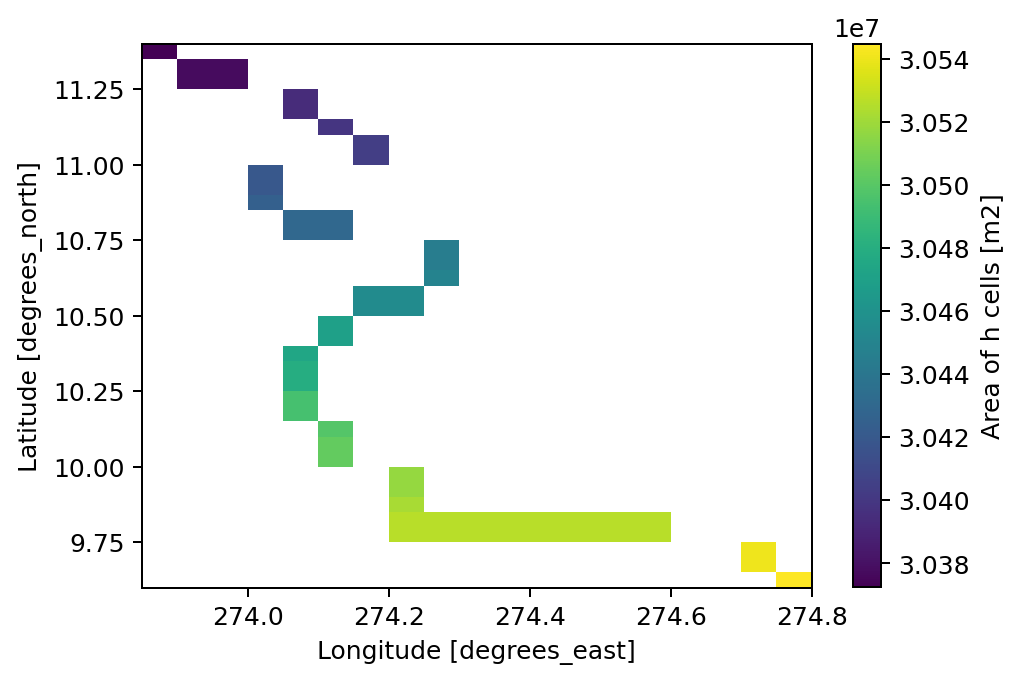

In [ ]:
Ut.plot()

In [218]:
dm = mask.to_pandas()
da = area.to_pandas()


In [231]:
print(dm.shape)
dm

(36, 19)


xh,273.875,273.925,273.975,274.025,274.075,274.125,274.175,274.225,274.275,274.325,274.375,274.425,274.475,274.525,274.575,274.625,274.675,274.725,274.775
yh,,,,,,,,,,,,,,,,,,,
9.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9.675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
9.725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
9.775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
9.825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
9.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10.025,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [232]:
print(da.shape)
da

(36, 19)


xh,273.875,273.925,273.975,274.025,274.075,274.125,274.175,274.225,274.275,274.325,274.375,274.425,274.475,274.525,274.575,274.625,274.675,274.725,274.775
yh,,,,,,,,,,,,,,,,,,,
9.625,3.054480e+07,3.054480e+07,3.054480e+07,3.054480e+07,3.054480e+07,3.054480e+07,3.054480e+07,3.054480e+07,3.054480e+07,3.054480e+07,3.054480e+07,3.054480e+07,3.054480e+07,3.054480e+07,3.054480e+07,3.054480e+07,3.054480e+07,3.054480e+07,3.054480e+07
9.675,3.054027e+07,3.054027e+07,3.054027e+07,3.054027e+07,3.054027e+07,3.054027e+07,3.054027e+07,3.054027e+07,3.054027e+07,3.054027e+07,3.054027e+07,3.054027e+07,3.054027e+07,3.054027e+07,3.054027e+07,3.054027e+07,3.054027e+07,3.054027e+07,3.054027e+07
9.725,3.053571e+07,3.053571e+07,3.053571e+07,3.053571e+07,3.053571e+07,3.053571e+07,3.053571e+07,3.053571e+07,3.053571e+07,3.053571e+07,3.053571e+07,3.053571e+07,3.053571e+07,3.053571e+07,3.053571e+07,3.053571e+07,3.053571e+07,3.053571e+07,3.053571e+07
9.775,3.053113e+07,3.053113e+07,3.053113e+07,3.053113e+07,3.053113e+07,3.053113e+07,3.053113e+07,3.053113e+07,3.053113e+07,3.053113e+07,3.053113e+07,3.053113e+07,3.053113e+07,3.053113e+07,3.053113e+07,3.053113e+07,3.053113e+07,3.053113e+07,3.053113e+07
9.825,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07
9.875,3.052191e+07,3.052191e+07,3.052191e+07,3.052191e+07,3.052191e+07,3.052191e+07,3.052191e+07,3.052191e+07,3.052191e+07,3.052191e+07,3.052191e+07,3.052191e+07,3.052191e+07,3.052191e+07,3.052191e+07,3.052191e+07,3.052191e+07,3.052191e+07,3.052191e+07
9.925,3.051726e+07,3.051726e+07,3.051726e+07,3.051726e+07,3.051726e+07,3.051726e+07,3.051726e+07,3.051726e+07,3.051726e+07,3.051726e+07,3.051726e+07,3.051726e+07,3.051726e+07,3.051726e+07,3.051726e+07,3.051726e+07,3.051726e+07,3.051726e+07,3.051726e+07
9.975,3.051259e+07,3.051259e+07,3.051259e+07,3.051259e+07,3.051259e+07,3.051259e+07,3.051259e+07,3.051259e+07,3.051259e+07,3.051259e+07,3.051259e+07,3.051259e+07,3.051259e+07,3.051259e+07,3.051259e+07,3.051259e+07,3.051259e+07,3.051259e+07,3.051259e+07
10.025,3.050789e+07,3.050789e+07,3.050789e+07,3.050789e+07,3.050789e+07,3.050789e+07,3.050789e+07,3.050789e+07,3.050789e+07,3.050789e+07,3.050789e+07,3.050789e+07,3.050789e+07,3.050789e+07,3.050789e+07,3.050789e+07,3.050789e+07,3.050789e+07,3.050789e+07


In [230]:
dt = dm*da
print(dt.shape)
dt

(50, 19)


xh,273.875,273.925,273.975,274.025,274.075,274.125,274.175,274.225,274.275,274.325,274.375,274.425,274.475,274.525,274.575,274.625,274.675,274.725,274.775
yh,,,,,,,,,,,,,,,,,,,
9.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.054480e+07
9.675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.054027e+07,NaN
9.725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,3.052653e+07,NaN,NaN,NaN,NaN
9.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.052191e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.051726e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [224]:
Utt

<xarray.DataArray (yh: 50, xh: 19)>
array([[              nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
        30544798.31382267],
       [              nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan, 30540266.30207422,
                      nan],
       [              nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
...
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan],
       [              nan, 30377683.90065287, 30377683.90065287,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan],
       [30372363.17763423,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan,               nan,               nan,
                      nan]])
Coordinates:
  * yh       (yh) float64 9.625 9.675 9.725 9.725 ... 11.27 11.28 11.32 11.38
  * xh       (xh) float64 273.9 273.9 274.0 274.0 ... 274.6 274.7 274.7 274.8

<Figure size 1080x720 with 0 Axes>

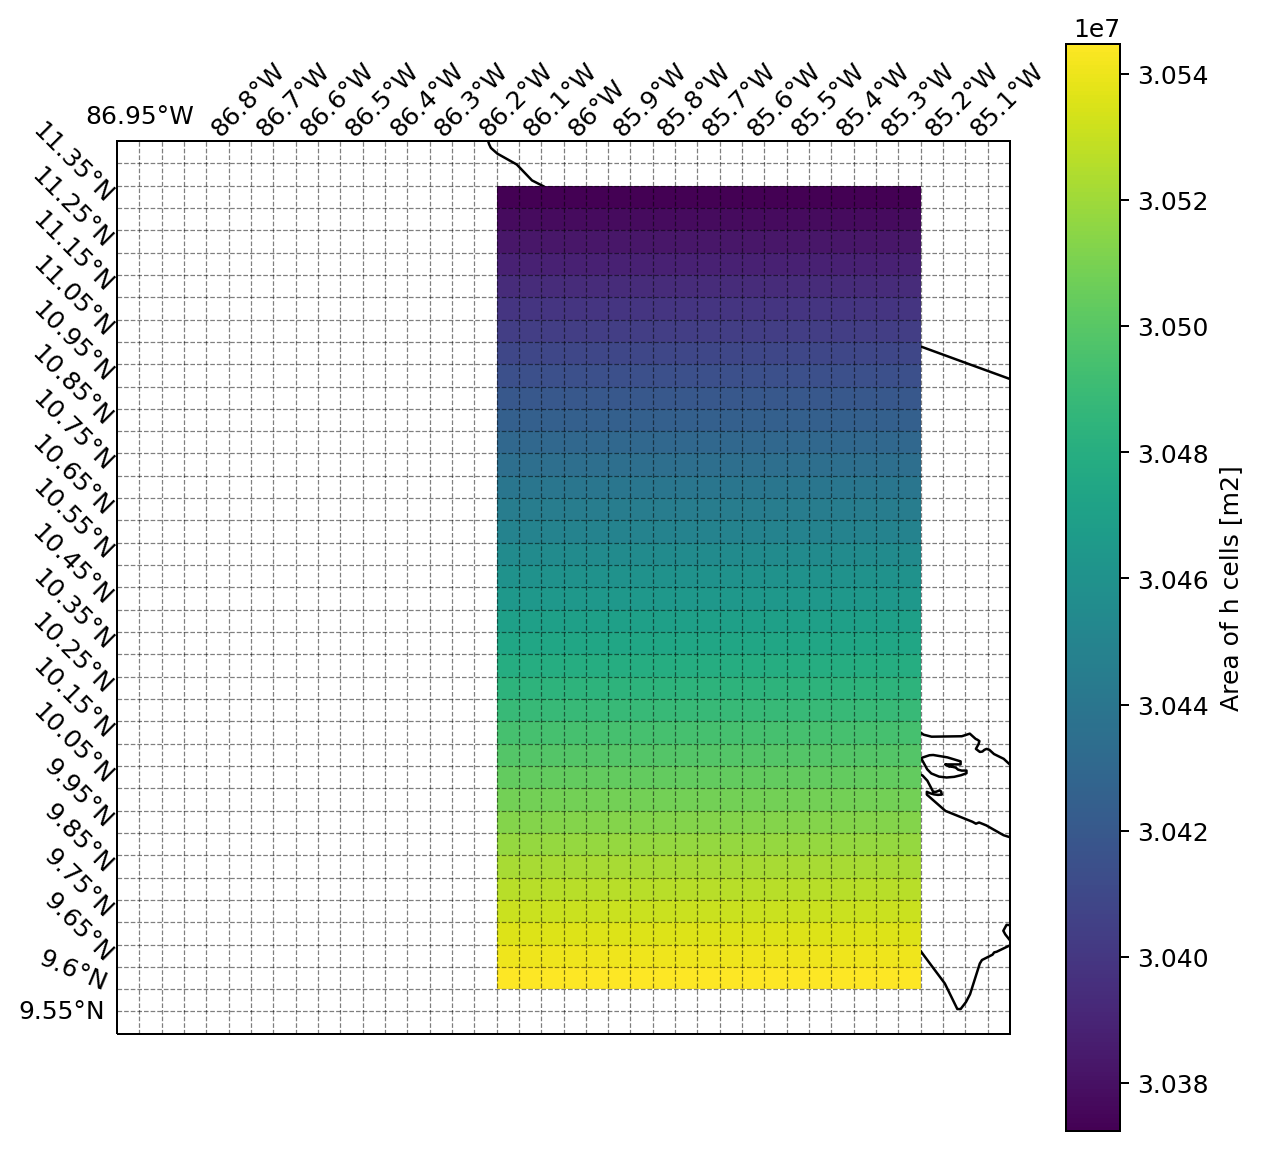

In [215]:
#import cartopy.io.img_tiles as cimgt
#Vertical Velocity & Ekman P. contour
import matplotlib.ticker as mticker

count = 0
plt.clf()

fig=plt.figure(figsize=(8,8))
for mes in np.arange(1,2,1):
             count+=1
             ax=fig.add_subplot(projection=cr.PlateCarree())
             #Ep_2[Ep_2.month==mes].squeeze().plot.contour(add_colorbar=True, cbar_kwargs={"label": "Ep [m/day]"}, levels = np.arange(-4,5,1), cmap='jet')
             ax.coastlines(resolution='10m')
             ax.add_feature(cf.BORDERS)
             ax.set_extent([-87, -85, 9.5,11.5])
             area.sel(xh=slice(273, 275), yh=slice(9.5, 11.5)).plot()   
             gl = ax.gridlines(crs=cr.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
             gl.top_labels = True
             gl.bottom_labels = False
             gl.left_labels = True
             gl.right_labels=False
             gl.xlines = True
             gl.xlocator = mticker.FixedLocator(np.arange(-87,-85,0.05))
             gl.ylocator = mticker.FixedLocator(np.arange(9.5,11.5,0.05))
#            mask.plot(add_colorbar= False)
#             plt.savefig("/glade/scratch/pmora/W_Ep_cont_00"+str(mes.values-1)+".jpeg", dpi=300)
#            fig.clear()
             plt.show()

In [ ]:
mask2 = np.ones(50)
lat2 = [9.625,9.675,9.725,9.725,9.775,9.825,9.825,9.775,9.825,9.825,9.825,9.825,9.875,9.925,9.975,10.025,10.075,10.125,10.125,10.175,10.225,10.275,10.325,10.375,10.425,10.475,10.525,10.575,10.625,10.675,10.725,10.775,10.775,10.825,10.825,10.875,10.925,10.975,10.975,10.975,11.025,11.075,11.125,11.175,11.225,11.275,11.275,11.325,11.375,11.425]
lon2 = [-85.175,-85.225,-85.275,-85.325,-85.375,-85.425,-85.475,-85.525,-85.575,-85.625,-85.675,-85.725,-85.725,-85.725,-85.725,-85.775,-85.825,-85.825,-85.875,-85.925,-85.925,-85.925,-85.925,-85.925,-85.875,-85.825,-85.825,-85.775,-85.725,-85.725,-85.725,-85.725,-85.775,-85.825,-85.875,-85.925,-85.925,-85.875,-85.825,-85.775,-85.775,-85.775,-85.825,-85.875,-85.925,-85.925,-85.975,-86.025,-86.075,-86.125]
df = pd.DataFrame({"mask":mask2, "lat":lat2, "lon":lon2})

df_pv = df.pivot(index="lat", columns="lon")
df_pv = df_pv.droplevel(0, axis=1)
#df_pv

mask2 = xr.DataArray(data=df_pv)*5


#df